In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datasets
import torch
import os
import re
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from Classifier import data_cleaning # created method to clean and extract data
from sklearn.model_selection import train_test_split
#-----------------------------------------------------
# Loading dataset
#-----------------------------------------------------
OGD_FakeSet = pd.read_csv("../data/OGD_FakeSet.csv")
#-----------------------------------------------------
# Cleaning dataset
#-----------------------------------------------------
df = data_cleaning(OGD_FakeSet)
#-----------------------------------------------------
# Vectorizing text in findings features
#-----------------------------------------------------
df['findings']
#-----------------------------------------------------
findings = df['findings']
def reverse(row):
    row = row[::-1]
    return row
#-----------------------------------------------------
findings_reverse = findings.apply(reverse)
#-----------------------------------------------------
sentences = pd.concat([findings, findings_reverse]) 
#-----------------------------------------------------
sentences = sentences.to_frame()
#-----------------------------------------------------
sentences['label'] = 0
sentences.reset_index(drop=True, inplace=True) 
for index in range(0,1000):
    sentences.at[index,'label']=1
#-----------------------------------------------------
train, test = train_test_split(sentences,test_size=0.3,random_state=1)
train.reset_index(drop=True)
#-----------------------------------------------------
train, validation = train_test_split(train,test_size=0.3,random_state=1)
train.reset_index(drop=True)
#-----------------------------------------------------
train_dataset = datasets.Dataset.from_pandas(train)
test_dataset = datasets.Dataset.from_pandas(test)
validation_dataset = datasets.Dataset.from_pandas(validation)
#-----------------------------------------------------
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])
validation_dataset = validation_dataset.remove_columns(["__index_level_0__"])
#-----------------------------------------------------
Dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset,"validation":validation_dataset})

In [2]:
Dict

DatasetDict({
    train: Dataset({
        features: ['findings', 'label'],
        num_rows: 980
    })
    test: Dataset({
        features: ['findings', 'label'],
        num_rows: 600
    })
    validation: Dataset({
        features: ['findings', 'label'],
        num_rows: 420
    })
})

In [20]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel
from transformers import BioGptTokenizer, BioGptModel

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
#tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1")
#tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)
#model = AutoModel.from_pretrained("dmis-lab/biobert-large-cased-v1.1", num_labels=2)
#model = BioGptModel.from_pretrained("microsoft/biogpt", num_labels=2)

In [21]:
# load dataset
df = sentences#pd.read_csv("data.csv")

# define function to preprocess data
def preprocess_function(data):
    return tokenizer(data["findings"], padding=True, truncation=True,max_length=10) 

# preprocess dataset
dataset = Dict.map(preprocess_function, batched=True, batch_size=None)


Map:   0%|          | 0/980 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [22]:
dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    print('.')
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

dataset_hidden = dataset.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

.


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

.


In [39]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])

y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])

X_train.shape, X_valid.shape

((980, 768), (420, 768))

In [40]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [41]:
lr_clf.score(X_valid, y_valid)

1.0

In [42]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.4928571428571429

In [43]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-7.867343,-11.388371,0
1,9.910344,-27.100847,0
2,11.525300,10.695387,1
3,10.317817,5.650483,1
4,1.327104,18.247217,1


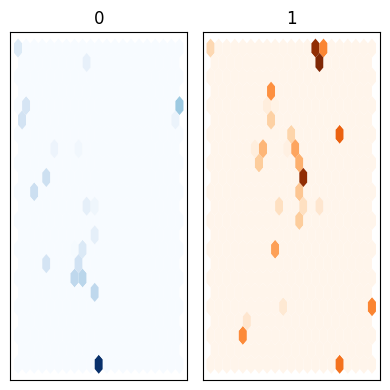

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(4,4))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = [0,1]#emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

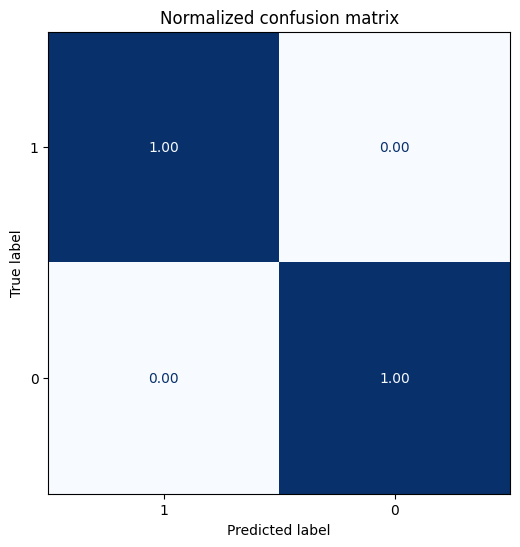

In [46]:
y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, [1,0])